# Assignment 1

**Author:** Igor Alentev

**Group:** BS20-RO-1

**Email:** i.alentev@innopolis.university

**Telegram:** [@m8dotpie](https://t.me/m8dotpie)


# Initialisation

## Installing necessary libraries

In [1]:
%%capture
"""
If you have any problems with this cell,
you should try removing capture directive.
"""
%pip install category_encoders

In [2]:
# Default utils
import pandas as pd
import numpy as np

# Plotting utils
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

# sklearn classes
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# sklearn utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Encoders
from category_encoders import OrdinalEncoder, OneHotEncoder


## PCA Implementation

In [42]:
"""
This is my implementation of the PCA algorithm.
It is designed to implement fit and transform
methods to become compatible with pipelines
and other components of ML.
"""
class myPCA:
    
    transformer = None # transformer of inputs
    n_components = 0   # number of dimensions

    def __init__(self, n_components=3):
        self.n_components = n_components

    # Construct the transformer
    def fit(self, X, y = None):
        scaled = StandardScaler().fit_transform(X)
        covMatrix = pd.DataFrame(scaled).cov()
        w, v = np.linalg.eig(covMatrix)
        wv = list(zip(w, v))

        def complex_key(elem):
            return elem[0]

        # Sort eigenvalues
        wv.sort(reverse=True, key=complex_key)

        # Compose a transformer from n_components largest eigvals
        self.transformer = np.array([v[1][:, np.newaxis] for v in wv[0:self.n_components]])
        return self

    # Apply the transformer to the input
    def transform(self, X):
        result = np.dot(X, self.transformer)
        result = result.reshape((result.shape[0], result.shape[1]))
        result = [[result[i][j].real for j in range(result.shape[1])] for i in range(result.shape[0])]
        result = np.array(result, dtype=np.float64)
        return result

# Dataset preparation

In [56]:
dataset = pd.read_csv('a1_dataset.csv')
dataset.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


## Datetime Conversion

In [57]:
# Convert datetime column to the specific type
dataset['var7'] = pd.to_datetime(dataset['var7'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

# Drop all the rows with wrong datetime
dataset = dataset.dropna(subset=['var7'])

# Split the date time into
dataset['year'] = dataset['var7'].dt.year
dataset['month'] = dataset['var7'].dt.month
dataset['day'] = dataset['var7'].dt.day
dataset['time'] = dataset['var7'].dt.hour * 60**2 + dataset['var7'].dt.minute * 60 + dataset['var7'].dt.second

# Since year has zero variance, we can drop it
dataset = dataset.drop(columns=['year', 'var7'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 924
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  920 non-null    int64  
 1   var1    920 non-null    float64
 2   var2    920 non-null    float64
 3   var3    920 non-null    object 
 4   var4    325 non-null    float64
 5   var5    920 non-null    float64
 6   var6    920 non-null    object 
 7   month   920 non-null    int64  
 8   day     920 non-null    int64  
 9   time    920 non-null    int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 79.1+ KB


# var4 Imputter

In [58]:
X = dataset.dropna(subset=['var4']).drop(columns=['var4', 'target'])
y = dataset.dropna(subset=['var4'])['var4']

## Polynomial Regression Imputer

In [59]:
# Degrees from 1 to 5 include linear regression
degrees = [1, 2, 3, 4, 5]
best_degree = 1
best_score = -1e32

tests = []

for i in range(len(degrees)):

    # Encode data
    column_transformer = ColumnTransformer([
        ('var3_transformer', OrdinalEncoder(), ['var3']),
        ('var6_transformer', OneHotEncoder(), ['var6']),
        ('column_transformer', StandardScaler(), ['var1', 'var2', 'var5'])
        ], remainder='passthrough')

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    
    pipeline = Pipeline([('col_trans', column_transformer),
                         ('polynomial_features', polynomial_features),
                         ('linear_regression', linear_regression)])

    # Cross-Validate result
    scores = cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_squared_error')

    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_degree = degrees[i]

    tests.append({"Degree": degrees[i], "MSE": -mean_score})

display(pd.DataFrame(tests))
print("Best degree: {}, Best score: {}".format(best_degree, best_score))


,Degree,MSE
0,1,614.376214
1,2,788.422877
2,3,1967.297459
3,4,5145.132350
4,5,15822.525568


Best degree: 1, Best score: -614.3762142993032


## Input lacked values

In [35]:
column_transformer = ColumnTransformer([
        ('var3_transformer', OrdinalEncoder(), ['var3']),
        ('var6_transformer', OneHotEncoder(), ['var6']),
        ('column_transformer', StandardScaler(), ['var1', 'var2', 'var5'])])
polynomial_features = PolynomialFeatures(degree=best_degree)
linear_regression = LinearRegression()

pipeline = Pipeline([('col_trans', column_transformer),
                         ('polynomial_features', polynomial_features),
                         ('linear_regression', linear_regression)])
pipeline.fit(X, y)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('var3_transformer',
                                                  OrdinalEncoder(), ['var3']),
                                                 ('var6_transformer',
                                                  OneHotEncoder(), ['var6']),
                                                 ('column_transformer',
                                                  StandardScaler(),
                                                  ['var1', 'var2', 'var5'])])),
                ('polynomial_features', PolynomialFeatures(degree=1)),
                ('linear_regression', LinearRegression())])

In [36]:
dataset['var4_pred'] = pipeline.predict(dataset.drop(columns=['target', 'var4']))
dataset['var4'] = np.where(dataset['var4'] > 0, dataset['var4'], dataset['var4_pred'])
dataset = dataset.drop(columns=['var4_pred'])
dataset.head(5)

,target,var1,var2,var3,var4,var5,var6,month,day,time
0,0,509.18,417.681,Micronesia,138.0,393.00,no,7,20,48097
1,0,446.06,666.182,Dominica,81.0,352.05,yes,4,4,77446
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,3,3,10777
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,3,19,28858
4,0,453.08,600.156,Cameroon,105.0,422.95,no,3,18,48155


# Data preprocessing

In [37]:
X, y = dataset.drop(columns=['target']), dataset['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Transformer for encoding and scaling
column_transformer = ColumnTransformer([
    ('ohe_encoder', OneHotEncoder(), ['var3', 'var6']),
    ('standard_scaler', StandardScaler(), ['var1', 'var2', 'var4', 'var5', 'time'])
], remainder='passthrough')

## PCA Plots

In [43]:
_pca1 = myPCA(n_components=1) # 1 dimension PCA
_pca2 = myPCA(n_components=2) # 2 dimension PCA
_pca3 = myPCA(n_components=3) # 3 dimension PCA

pipeline1 = Pipeline([('trans', column_transformer), ('pca', _pca1)])
pipeline2 = Pipeline([('trans', column_transformer), ('pca', _pca2)])
pipeline3 = Pipeline([('trans', column_transformer), ('pca', _pca3)])

X_1 = pipeline1.fit(X_train).transform(X_train)
X_2 = pipeline2.fit(X_train).transform(X_train)
X_3 = pipeline3.fit(X_train).transform(X_train)

## 1-d PCA

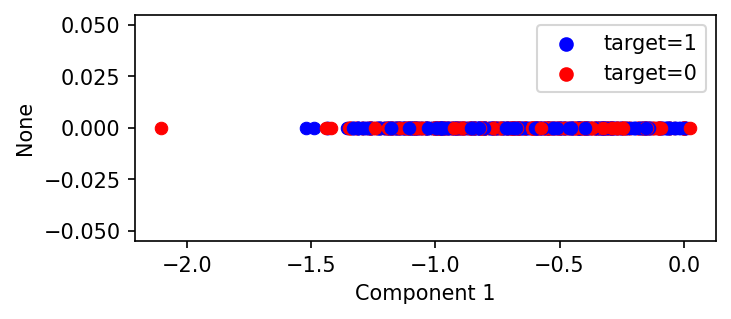

In [51]:
fig = plt.figure(figsize=(5, 2))
ax1 = fig.add_subplot(1, 1, 1)

ax1.set_xlabel('Component 1')
ax1.set_ylabel('None')

# ax1.set_xlim((-0.3, 0.3))
# ax1.set_ylim((-0.5, 0.5))

ax1.scatter(0, 0, color='blue', label='target=1')
ax1.scatter(0, 0, color='red', label='target=0')

for i in range(len(X_1)):
    x_c, y_c = X_1[i][0], 0
    color = 'blue'
    if y_train.values[i] == 0:
        color = 'red'
    ax1.scatter(x_c, y_c, color=color, linewidth=0.5)

plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})

plt.legend()
plt.gcf().set_dpi(150)
plt.savefig('assets/pca-1d.png')

## 2-D PCA, 3-D PCA

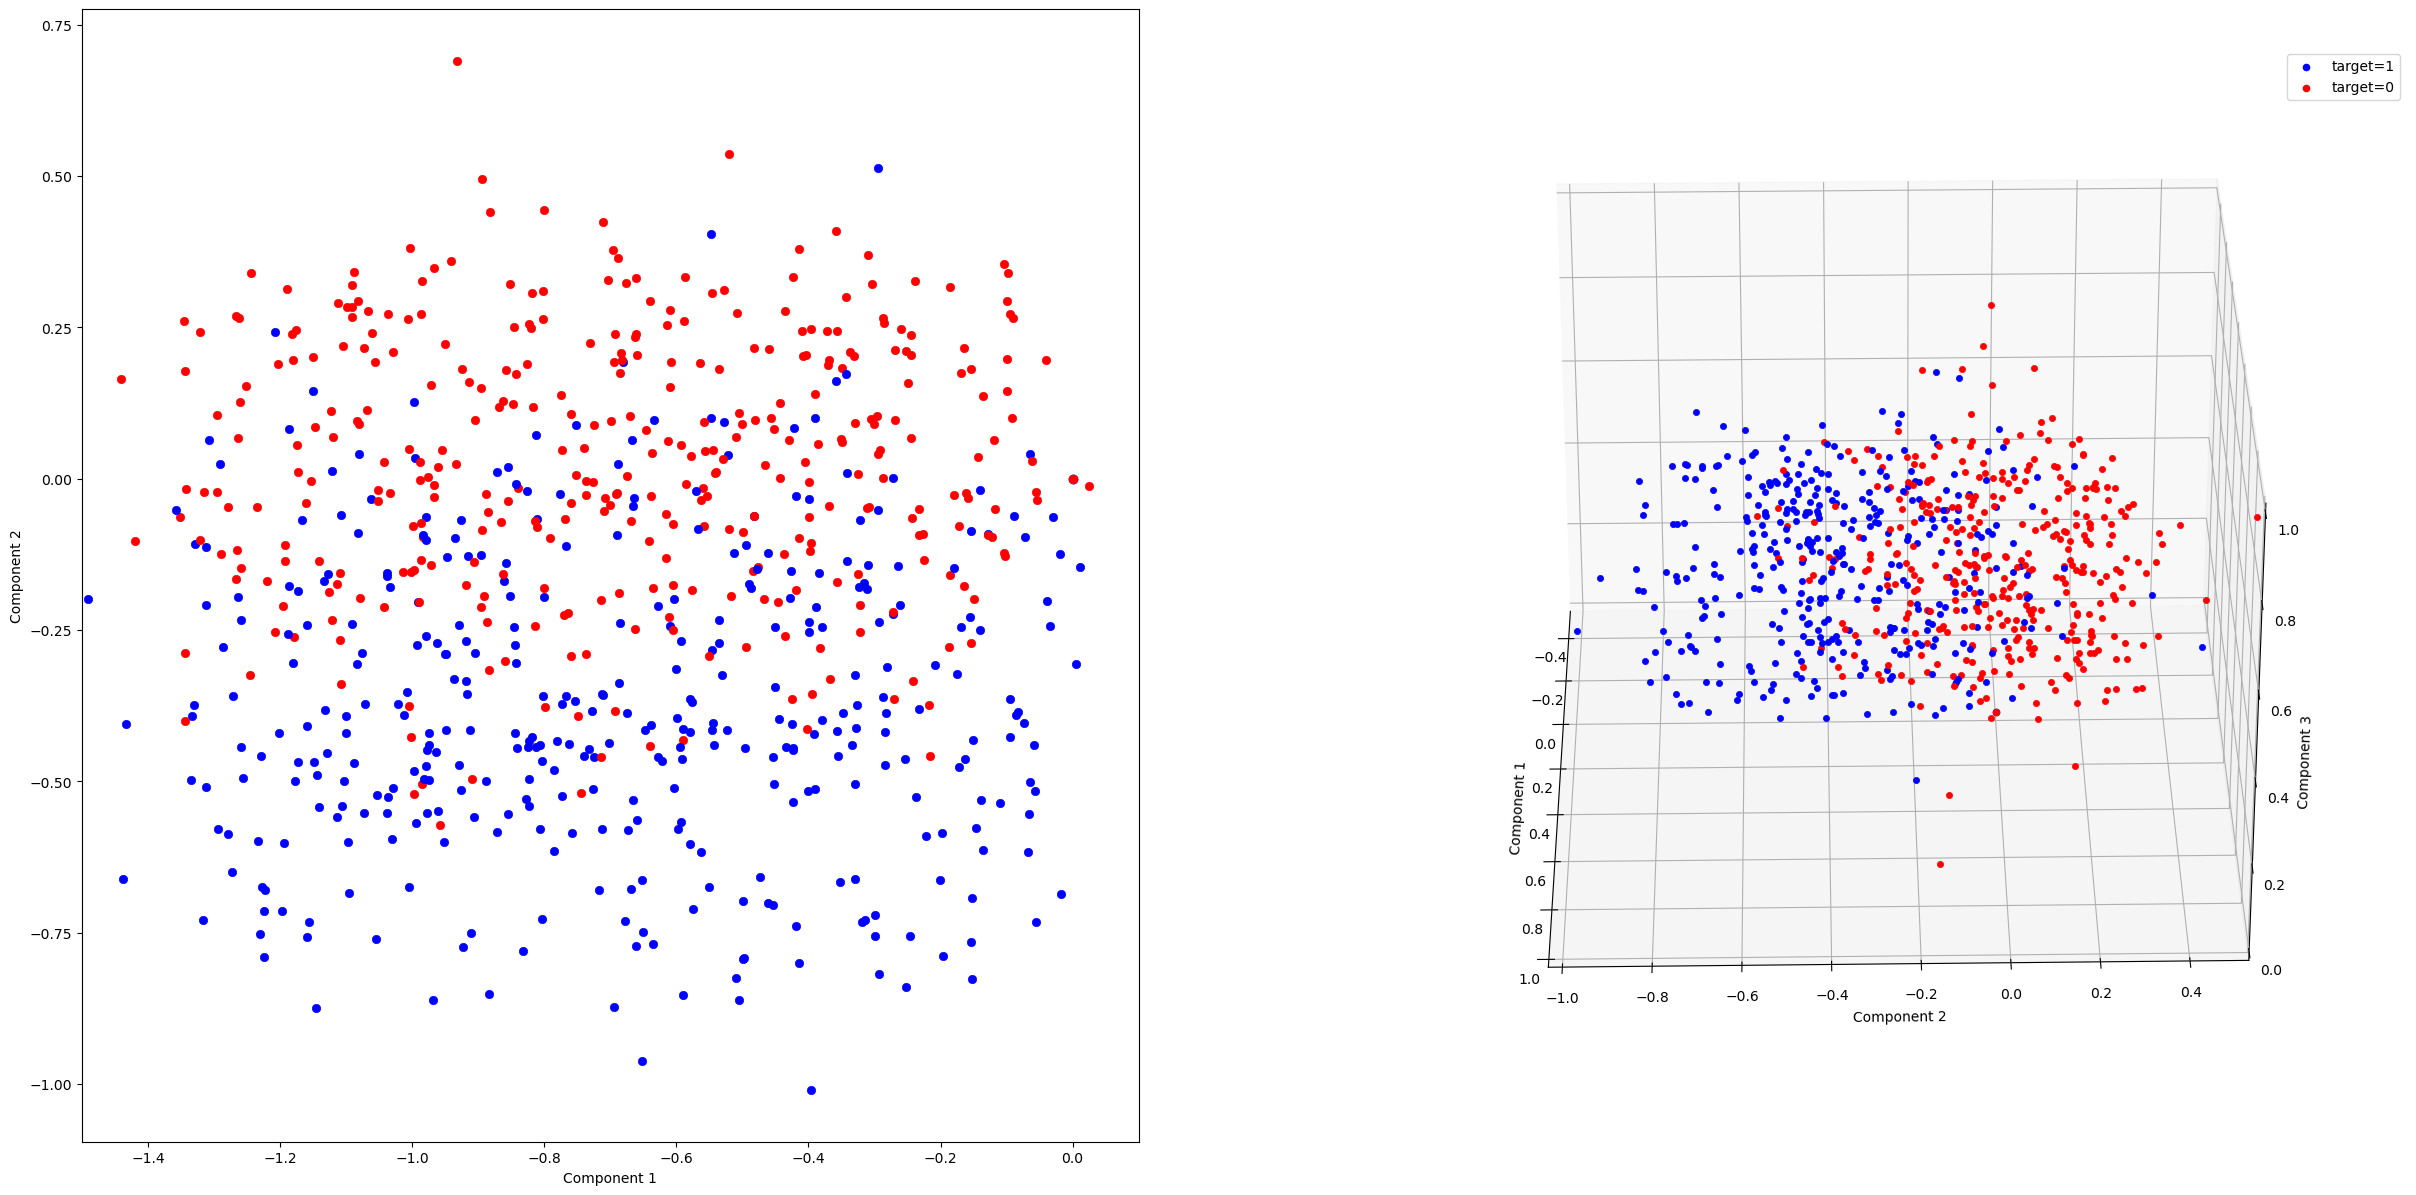

In [52]:
from cProfile import label
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(30, 15))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

ax3.set_xlabel('Component 1')
ax3.set_ylabel('Component 2')
ax3.set_zlabel('Component 3')

# var4 through var3
ax2.set_xlim((-1.5, 0.1))
# ax2.set_ylim((-0.2, 0.2))
ax3.set_xlim((-0.5, 1))
ax3.set_ylim((-1, 0.50))
ax3.set_zlim((0, 1))

# var4 without var3
# ax2.set_xlim((-0.02, 0.03))
# ax2.set_ylim((-0.1, 0.1))
# ax3.set_xlim((-1, 10))
# ax3.set_ylim((-0.10, 0.10))
# ax3.set_zlim((-1, 1))

ax2.scatter(0, 0, color='blue', label='target=1')
ax2.scatter(0, 0, color='red', label='target=0')
ax3.scatter(0, 0, 0, color='blue', label='target=1')
ax3.scatter(0, 0, 0, color='red', label='target=0')

for i in range(len(X_2)):
    x_c, y_c = X_2[i]
    color = 'blue'
    if y_train.values[i] == 0:
        color = 'red'
    ax2.scatter(x_c, y_c, color=color, linewidth=0.5)

for i in range(len(X_3)):
    x_c, y_c, z_c = X_3[i]
    color = 'blue'
    if y_train.values[i] == 0:
        color = 'red'
    ax3.scatter(x_c, y_c, z_c, color=color, linewidth=0.5)

for angle in range(0,360): 
    ax3.view_init(30, angle)

plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})

plt.legend()

plt.gcf().set_dpi(100)
plt.savefig('assets/pca-2d3d.png')

# Training

## Models Initialisation

In [16]:
param_grid_lr = [{"model__max_iter": [10000], 'model__solver': ['liblinear'], 'model__tol': np.logspace(-3, 3, 10), 
                  "model__C": np.logspace(-3, 3, 10), "model__penalty": ["l1", "l2"]},
                 {"model__max_iter": [10000], 'model__solver': ['newton-cg', 'sag', 'lbfgs'], 
                  'model__tol': np.logspace(-3, 3, 10), "model__C": np.logspace(-3, 3, 10), "model__penalty": ['l2']}]
param_grid_kn = {'model__n_neighbors':list(range(1, 100)), 'model__weights': ['uniform', 'distance'], 
                 'model__metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine']}
param_grid_nb = {'model__var_smoothing': np.logspace(0,-9, num=100)}

models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000), param_grid_lr),
    ('K-Neighbors', KNeighborsClassifier(n_neighbors=42), param_grid_kn),
    ('Naive Bayes', GaussianNB(), param_grid_nb)
]

## Raw Models Testing

In [17]:
for name, model, _ in models:
    pipeline = Pipeline([
        ('column_transformer', column_transformer),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    acc_score = metrics.accuracy_score(y_test, y_pred)
    prec_score = metrics.precision_score(y_test, y_pred)
    rec_score = metrics.recall_score(y_test, y_pred)

    print('Model: {}\n [accuracy: {}, precision: {}, recall: {}]\n'.format(name, acc_score, prec_score, rec_score))

Model: Logistic Regression
 [accuracy: 0.9728260869565217, precision: 0.9550561797752809, recall: 0.9883720930232558]

Model: K-Neighbors
 [accuracy: 0.9456521739130435, precision: 1.0, recall: 0.8837209302325582]

Model: Naive Bayes
 [accuracy: 0.5163043478260869, precision: 0.48717948717948717, recall: 0.6627906976744186]



## Grid Search With Cross-Validation

In [21]:
for name, model, param_grid in models:
    pipeline = Pipeline([
        ('column_transformer', column_transformer),
        ('model', model)
    ])

    grid_search_clf = GridSearchCV(estimator=pipeline, cv=3, scoring='accuracy', param_grid=param_grid)
    grid_search_clf.fit(X_train, y_train)

    y_pred = grid_search_clf.predict(X_test)
    acc_score = metrics.accuracy_score(y_test, y_pred)
    prec_score = metrics.precision_score(y_test, y_pred)
    rec_score = metrics.recall_score(y_test, y_pred)

    print('Model: {}'.format(name))
    print(' [accuracy: {}, precision: {}, recall: {}]'.format(acc_score, prec_score, rec_score))
    display(pd.DataFrame([grid_search_clf.best_params_]))

Model: Logistic Regression
 [accuracy: 0.9728260869565217, precision: 0.9550561797752809, recall: 0.9883720930232558]


,model__C,model__max_iter,model__penalty,model__solver,model__tol
0,2.154435,10000,l2,lbfgs,2.154435


Model: K-Neighbors
 [accuracy: 0.9510869565217391, precision: 0.9873417721518988, recall: 0.9069767441860465]


,model__metric,model__n_neighbors,model__weights
0,manhattan,35,distance


Model: Naive Bayes
 [accuracy: 0.9728260869565217, precision: 0.9764705882352941, recall: 0.9651162790697675]


,model__var_smoothing
0,0.001874


## PCA + GridSearchCV

In [50]:
for name, model, param_grid in models:
    pipeline = Pipeline([
        ('column_transformer', column_transformer),
        ('pca', myPCA(n_components=3)),
        ('model', model)
    ])

    grid_search_clf = GridSearchCV(estimator=pipeline, cv=3, scoring='accuracy', param_grid=param_grid)
    grid_search_clf.fit(X_train, y_train)

    y_pred = grid_search_clf.predict(X_test)
    acc_score = metrics.accuracy_score(y_test, y_pred)
    prec_score = metrics.precision_score(y_test, y_pred)
    rec_score = metrics.recall_score(y_test, y_pred)

    print('Model: {}'.format(name))
    print(' [accuracy: {}, precision: {}, recall: {}]'.format(acc_score, prec_score, rec_score))
    display(pd.DataFrame([grid_search_clf.best_params_]))

Model: Logistic Regression
 [accuracy: 0.8369565217391305, precision: 0.8414634146341463, recall: 0.8023255813953488]


,model__C,model__max_iter,model__penalty,model__solver,model__tol
0,0.464159,10000,l1,liblinear,0.464159


Model: K-Neighbors
 [accuracy: 0.7934782608695652, precision: 0.8076923076923077, recall: 0.7325581395348837]


,model__metric,model__n_neighbors,model__weights
0,chebyshev,11,distance


Model: Naive Bayes
 [accuracy: 0.8043478260869565, precision: 0.7976190476190477, recall: 0.7790697674418605]


,model__var_smoothing
0,0.02848
